In [4]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Otherwise plt.savefig crashes with latex errors
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# Broken vs working metric

In [5]:
metric_path = '/scratch/ben.patterson/pe_4d_pipeline/dataslot_4_test/initial_metric'
with open(metric_path, 'rb') as fp:
        working_metric = pickle.load(fp)
working_base = {'chirp_mass': 42.97439046093637, 'symmetric_mass_ratio': 0.249, 'chi_eff': 0.4316106559960793, 'ecc10sqrd': 0}

metric_path = '/scratch/ben.patterson/pe_4d_pipeline/dataslot_4_test2/initial_metric'
with open(metric_path, 'rb') as fp:
        broken_metric = pickle.load(fp)
broken_base = {'chirp_mass': 42.94404219230573, 'symmetric_mass_ratio': 0.249, 'chi_eff': 0.4289437303099044, 'ecc10sqrd': 0}

In [3]:
def find_degen_shifts(metric, target_par, target_dist):
    
    # Find B
    keys = list(metric.dxs.keys())
    target_ind = keys.index(target_par)
    param_keys = [key for key in keys if key != target_par]
    B = np.array([metric.metric[target_ind][k] for k in range(len(keys)) if k != target_ind])

    # Find inverse of C
    C = np.delete(metric.metric, (target_ind), axis=0)
    C = np.delete(C, (target_ind), axis=1)
    C_inv = np.linalg.inv(C)

    # Calculate shifts in each direction
    BC_inv = np.matmul(B, C_inv)
    degen_shifts = {target_par: target_dist}
    for i, key in enumerate(param_keys):
        degen_shifts[key] = -BC_inv[i]*target_dist

    return degen_shifts

/home/ben.patterson/projects/simple-pe/simple_pe/param_est/metric.py:255: RuntimeWarning: invalid value encountered in sqrt
  evec*np.sqrt(self.mismatch/evals)))


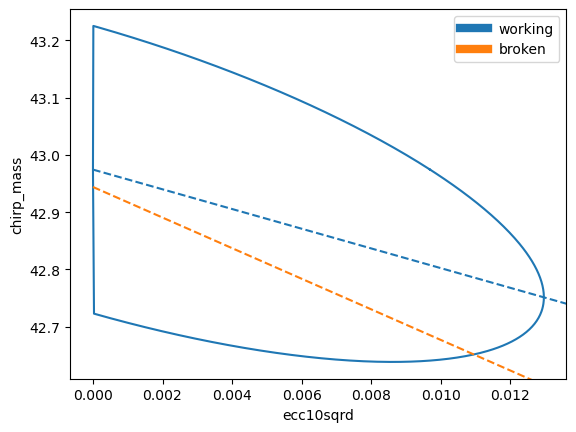

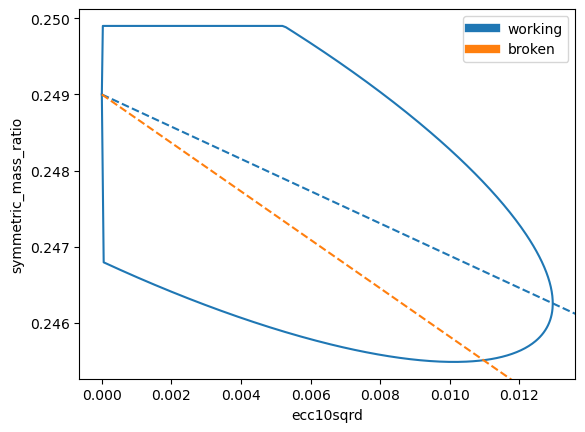

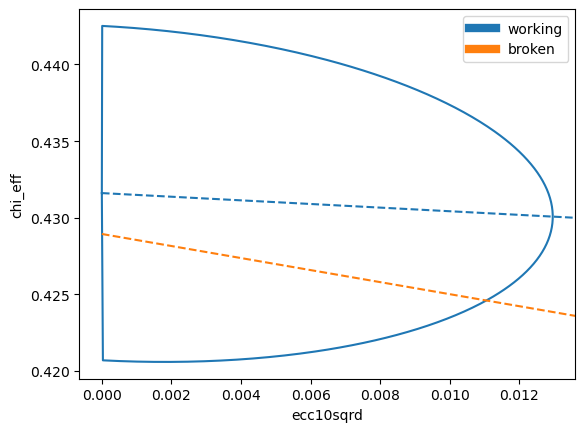

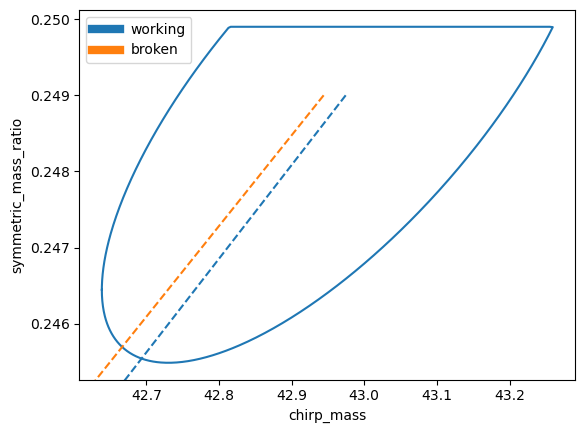

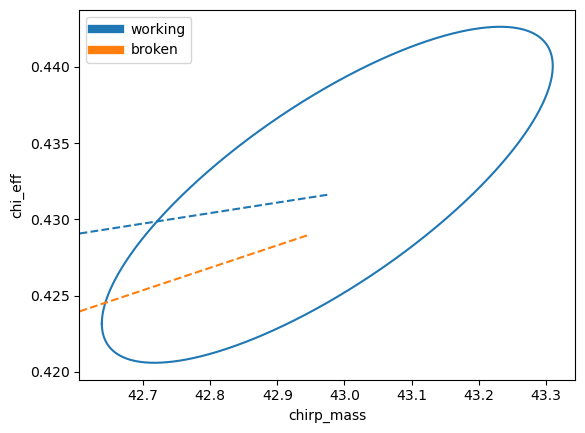

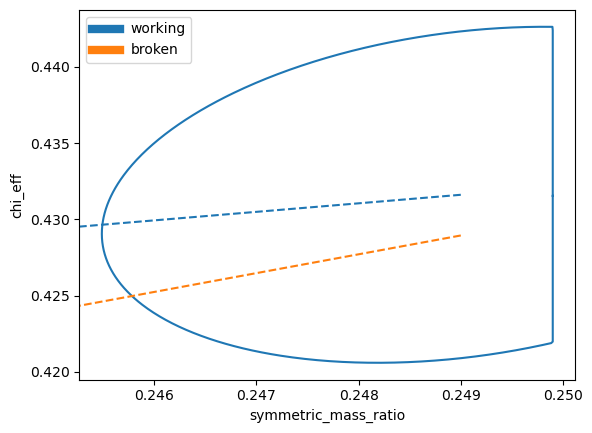

In [6]:
keys = ['ecc10sqrd', 'chirp_mass', 'symmetric_mass_ratio', 'chi_eff']
de2 = 0.15
working_shifts = find_degen_shifts(working_metric, 'ecc10sqrd', de2)
broken_shifts = find_degen_shifts(broken_metric, 'ecc10sqrd', de2)

for i in range(4):
    for j in range(i+1, 4):

        # Plot projected ellipse
        working_metric.project_metric([keys[i], keys[j]])
        broken_metric.project_metric([keys[i], keys[j]])
        working_ellipse = working_metric.generate_ellipse(npts=1000, scale=0.1, projected=True)
        broken_ellipse = broken_metric.generate_ellipse(npts=1000, scale=0.1, projected=True)
        plt.plot(working_ellipse[keys[i]], working_ellipse[keys[j]], c='C0', label='working')
        plt.plot(broken_ellipse[keys[i]], broken_ellipse[keys[j]], c='C1', label='broken')

        # Plot degeneracy line
        xlims = plt.gca().get_xlim()
        ylims = plt.gca().get_ylim()
        plt.plot([working_base[keys[i]], working_base[keys[i]]+working_shifts[keys[i]]],
                 [working_base[keys[j]], working_base[keys[j]]+working_shifts[keys[j]]],
                 c='C0', ls='dashed')
        plt.plot([broken_base[keys[i]], broken_base[keys[i]]+broken_shifts[keys[i]]],
                 [broken_base[keys[j]], broken_base[keys[j]]+broken_shifts[keys[j]]],
                 c='C1', ls='dashed')
        plt.xlim(xlims)        
        plt.ylim(ylims)        
        plt.xlabel(keys[i])
        plt.ylabel(keys[j])
        plt.legend()
        plt.show()

In [4]:
working_metric.metric

array([[ 1.56630600e+00,  7.95471321e-02,  1.60406540e-01,
        -1.61453803e+00],
       [ 7.95471321e-02,  9.70553947e-03, -3.06060635e-01,
        -1.91150090e-01],
       [ 1.60406540e-01, -3.06060635e-01,  2.25445489e+01,
         5.50998376e+00],
       [-1.61453803e+00, -1.91150090e-01,  5.50998376e+00,
         4.28669733e+00]])

In [5]:
broken_metric.metric

array([[ 1.56115488e+00,  7.98265940e-02,  3.58474495e-01,
        -1.60151352e+00],
       [ 7.98265940e-02,  9.72804508e-03, -3.29487415e-01,
        -1.91319999e-01],
       [ 3.58474495e-01, -3.29487415e-01,  2.16944442e+01,
         5.73964272e+00],
       [-1.60151352e+00, -1.91319999e-01,  5.73964272e+00,
         4.28241042e+00]])

In [6]:
def const_mm_point(metric, target_par='ecc10sqrd'):

    # Find A
    keys = list(metric.dxs.keys())
    target_ind = keys.index(target_par)
    A = metric.metric[target_ind][target_ind]

    # Find B
    param_keys = [key for key in keys if key != target_par]
    B = np.array([metric.metric[target_ind][k] for k in range(len(keys)) if k != target_ind])

    # Find inverse of C
    C = np.delete(metric.metric, (target_ind), axis=0)
    C = np.delete(C, (target_ind), axis=1)
    C_inv = np.linalg.inv(C)

    # Find change in target parameter to reach mismatch
    BC_term = -np.matmul(B, np.matmul(C_inv, B))
    print(keys)
    print(np.matmul(C_inv, B))
    print(A)
    print(BC_term)
    print(A+BC_term)

In [7]:
const_mm_point(working_metric)
const_mm_point(broken_metric)

['ecc10sqrd', 'chirp_mass', 'symmetric_mass_ratio', 'chi_eff']
[17.2054649   0.21175818  0.11839044]
1.5663059999058266
-1.2114669100843718
0.35483908982145485
['ecc10sqrd', 'chirp_mass', 'symmetric_mass_ratio', 'chi_eff']
[26.70633861  0.31826425  0.39258733]
1.5611548826702457
-1.6172317451143265
-0.05607686244408083


In [8]:
broken_metric.evec

array([ 2.34226974e+01,  3.77588317e+00,  3.49243998e-01,
       -8.70234586e-05])

In [9]:
working_metric.evals

array([2.40869813e+01, 3.86734818e+00, 4.52400236e-01,
       5.28085168e-04])

In [10]:
np.matmul(working_metric.metric, working_metric.evec.T[-1])/working_metric.evec.T[-1]

array([0.00052809, 0.00052809, 0.00052809, 0.00052809])

In [11]:
working_metric.evec.T[-1]

array([-0.02563356,  0.99932648,  0.00760676,  0.02513243])

In [13]:
np.linalg.eig(working_metric.coordinate_metric)

(array([0.02798247, 0.01035881, 0.00150213, 0.00035476]),
 array([[ 0.41197526,  0.69090892, -0.53309066, -0.26217474],
        [ 0.58707272, -0.03045833,  0.01645166,  0.80879371],
        [-0.3882512 ,  0.72192136,  0.48851781,  0.29906671],
        [-0.57869078, -0.02338158, -0.69057515,  0.43321617]]))

In [21]:
dx_inv = np.linalg.inv(broken_metric.dxs.samples)
np.matmul(dx_inv.T, np.matmul(broken_metric.coordinate_metric, dx_inv))

array([[ 1.56115488e+00,  7.98265940e-02,  3.58474495e-01,
        -1.60151352e+00],
       [ 7.98265940e-02,  9.72804508e-03, -3.29487415e-01,
        -1.91319999e-01],
       [ 3.58474495e-01, -3.29487415e-01,  2.16944442e+01,
         5.73964272e+00],
       [-1.60151352e+00, -1.91319999e-01,  5.73964272e+00,
         4.28241042e+00]])

In [16]:
broken_metric.metric

array([[ 1.56115488e+00,  7.98265940e-02,  3.58474495e-01,
        -1.60151352e+00],
       [ 7.98265940e-02,  9.72804508e-03, -3.29487415e-01,
        -1.91319999e-01],
       [ 3.58474495e-01, -3.29487415e-01,  2.16944442e+01,
         5.73964272e+00],
       [-1.60151352e+00, -1.91319999e-01,  5.73964272e+00,
         4.28241042e+00]])

In [18]:
working_metric.dxs

{'ecc10sqrd': Array([0.08048149, 0.        , 0.        , 0.        ]),
 'chirp_mass': Array([0.       , 1.0092725, 0.       , 0.       ]),
 'symmetric_mass_ratio': Array([0.        , 0.        , 0.02106835, 0.        ]),
 'chi_eff': Array([0.       , 0.       , 0.       , 0.0486826])}

In [19]:
broken_metric.dxs

{'ecc10sqrd': Array([0.07909564, 0.        , 0.        , 0.        ]),
 'chirp_mass': Array([0.        , 1.00782145, 0.        , 0.        ]),
 'symmetric_mass_ratio': Array([0.        , 0.        , 0.02137587, 0.        ]),
 'chi_eff': Array([0.        , 0.        , 0.        , 0.04840138])}

# Shifting to lower eta

In [6]:
metric_path = '/scratch/ben.patterson/pe_4d_pipeline/dataslot_4_test3/initial_metric'
with open(metric_path, 'rb') as fp:
        metric_024 = pickle.load(fp)
base_024 = {'chirp_mass': 42.93678551419538, 'symmetric_mass_ratio': 0.24985685792399245, 'chi_eff': 0.4295669225082764, 'ecc10sqrd': 0}
fid_024 = {'ecc10sqrd': 0.009491882472882558, 'chirp_mass': 42.84362806039099, 'symmetric_mass_ratio': 0.24948515945781724, 'chi_eff': 0.4295076130908695}

metric_path = '/scratch/ben.patterson/pe_4d_pipeline/dataslot_4_test4/initial_metric'
with open(metric_path, 'rb') as fp:
        metric_023 = pickle.load(fp)
base_023 = {'chirp_mass': 42.898188346407835, 'symmetric_mass_ratio': 0.2499999695883393, 'chi_eff': 0.4267164343062718, 'ecc10sqrd': 0}
fid_023 = {'ecc10sqrd': 0.009093147707913382, 'chirp_mass': 42.82788896996512, 'symmetric_mass_ratio': 0.24986780151514412, 'chi_eff': 0.42719672123549896}

metric_path = '/scratch/ben.patterson/pe_4d_pipeline/dataslot_4_test5/initial_metric'
with open(metric_path, 'rb') as fp:
        metric_022 = pickle.load(fp)
base_022 = {'chirp_mass': 42.898188346407835, 'symmetric_mass_ratio': 0.2499999695883393, 'chi_eff': 0.4267164343062718, 'ecc10sqrd': 0}
fid_022 = {'ecc10sqrd': 0.00952886743079716, 'chirp_mass': 42.86540135952645, 'symmetric_mass_ratio': 0.2500200211510992, 'chi_eff': 0.4287575133505612}

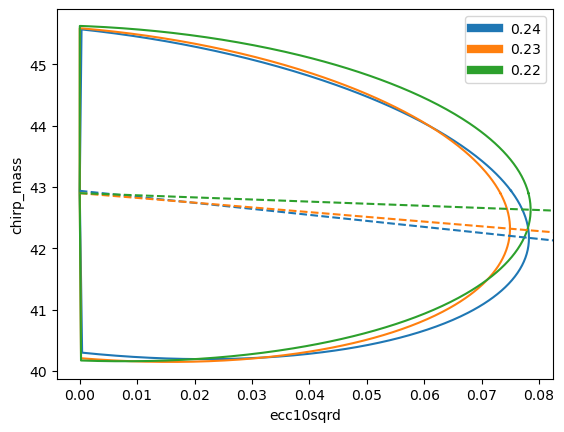

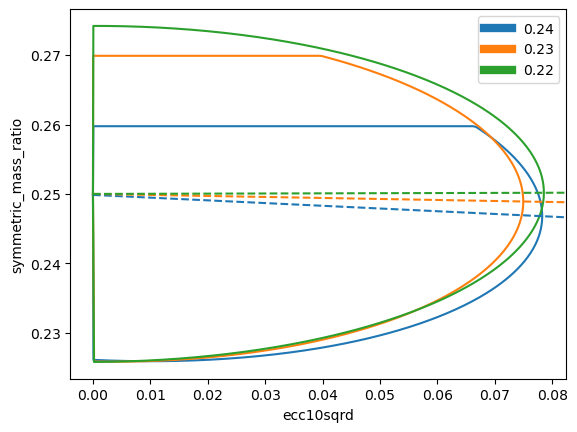

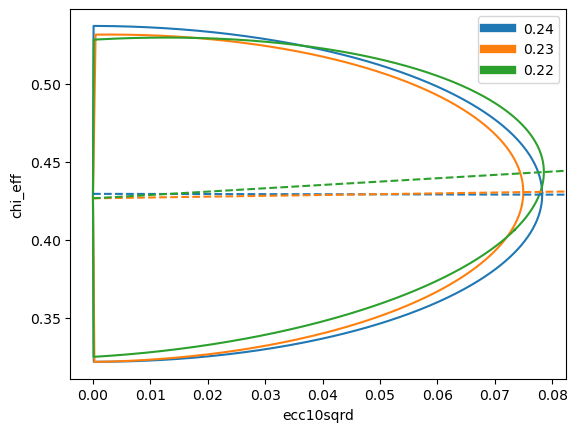

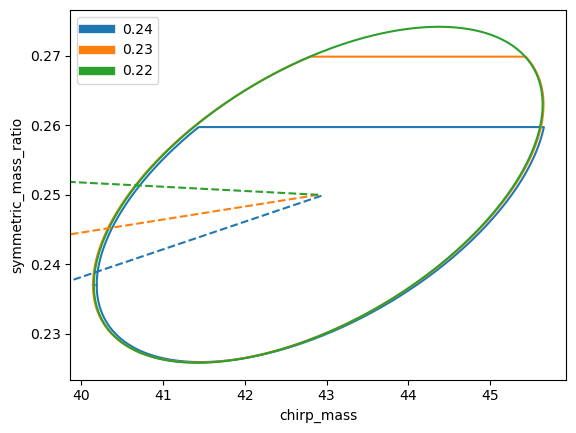

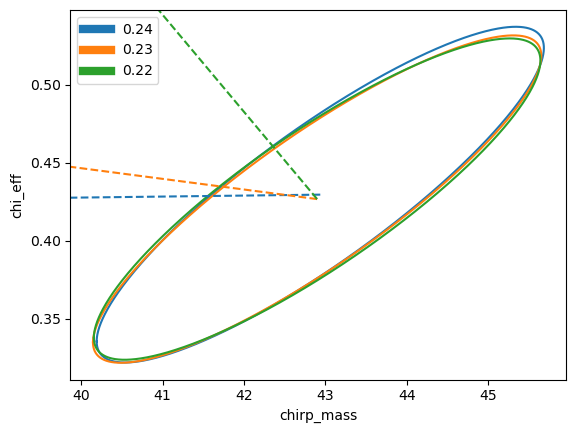

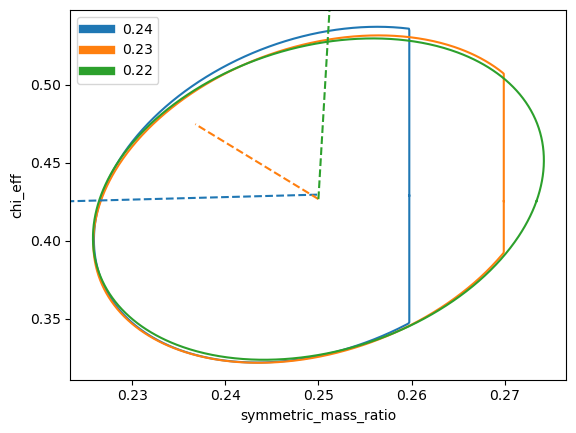

In [9]:
keys = ['ecc10sqrd', 'chirp_mass', 'symmetric_mass_ratio', 'chi_eff']

for i in range(4):
    for j in range(i+1, 4):

        # Plot projected ellipse
        metric_024.project_metric([keys[i], keys[j]])
        metric_023.project_metric([keys[i], keys[j]])
        metric_022.project_metric([keys[i], keys[j]])
        ellipse_024 = metric_024.generate_ellipse(npts=1000, scale=1, projected=True)
        ellipse_023 = metric_023.generate_ellipse(npts=1000, scale=1, projected=True)
        ellipse_022 = metric_022.generate_ellipse(npts=1000, scale=1, projected=True)
        if keys[i] == 'symmetric_mass_ratio' or keys[j] == 'symmetric_mass_ratio':
            ellipse_024['symmetric_mass_ratio'] += base_024['symmetric_mass_ratio'] - 0.24
            ellipse_023['symmetric_mass_ratio'] += base_023['symmetric_mass_ratio'] - 0.23
            ellipse_022['symmetric_mass_ratio'] += base_022['symmetric_mass_ratio'] - 0.22
        plt.plot(ellipse_024[keys[i]], ellipse_024[keys[j]], c='C0', label='0.24')
        plt.plot(ellipse_023[keys[i]], ellipse_023[keys[j]], c='C1', label='0.23')  
        plt.plot(ellipse_022[keys[i]], ellipse_022[keys[j]], c='C2', label='0.22')
        xlim = plt.gca().get_xlim()
        ylim = plt.gca().get_ylim()
        plt.plot([base_024[keys[i]], base_024[keys[i]]+100*(fid_024[keys[i]]-base_024[keys[i]])],
                 [base_024[keys[j]], base_024[keys[j]]+100*(fid_024[keys[j]]-base_024[keys[j]])], c='C0', ls='dashed')
        plt.plot([base_023[keys[i]], base_023[keys[i]]+100*(fid_023[keys[i]]-base_023[keys[i]])],
                 [base_023[keys[j]], base_023[keys[j]]+100*(fid_023[keys[j]]-base_023[keys[j]])], c='C1', ls='dashed')
        plt.plot([base_022[keys[i]], base_022[keys[i]]+100*(fid_022[keys[i]]-base_022[keys[i]])],
                 [base_022[keys[j]], base_022[keys[j]]+100*(fid_022[keys[j]]-base_022[keys[j]])], c='C2', ls='dashed')
        plt.xlabel(keys[i])
        plt.ylabel(keys[j])
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.legend()
        plt.show()

In [1]:
from pycbc.waveform import td_approximants, fd_approximants

# List of td approximants that are available
print(td_approximants())

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new
['TaylorT1', 'TaylorT2', 'TaylorT3', 'SpinTaylorT1', 'SpinTaylorT4', 'SpinTaylorT5', 'PhenSpinTaylor', 'PhenSpinTaylorRD', 'EOBNRv2', 'EOBNRv2HM', 'TEOBResum_ROM', 'SEOBNRv1', 'SEOBNRv2', 'SEOBNRv2_opt', 'SEOBNRv3', 'SEOBNRv3_pert', 'SEOBNRv3_opt', 'SEOBNRv3_opt_rk4', 'SEOBNRv4', 'SEOBNRv4_opt', 'SEOBNRv4P', 'SEOBNRv4PHM', 'SEOBNRv2T', 'SEOBNRv4T', 'SEOBNRv4_ROM_NRTidalv2', 'SEOBNRv4_ROM_NRTidalv2_NSBH', 'HGimri', 'IMRPhenomA', 'IMRPhenomB', 'IMRPhenomC', 'IMRPhenomD', 'IMRPhenomD_NRTidalv2', 'IMRPhenomNSBH', 'IMRPhenomHM', 'IMRPhenomPv2', 'IMRPhenomPv2_NRTidal', 'IMRPhenomPv2_NRTidalv2', 'TaylorEt', 'TaylorT4', 'EccentricTD', 'SpinDominatedWf', 'NR_hdf5', 'NRSur7dq2', 'NRSur7dq4', 'SEOBNRv4HM', 'NRHybSur3dq8', 'IMRPhenomXAS', 'IMRPhenomXHM', 'IMRPhenomPv3', 'IMRPhenomPv3HM', 'IMRPhenomXP', 'IMRPhenomXPHM', 'TEOBResumS', 'IMRPhenomT', 'IMRPhenomTHM', 'IMRPhenomTP', 'IMRPhenomTPHM', 'SEOBNRv4HM